In [23]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from ipywidgets import IntProgress
from tqdm import tqdm
from PIL import Image
from time import time

from dataset import FootballFrameDataset
from models import *
from evaluate import *

In [24]:
train = pd.read_csv('data/train.csv', index_col=[0])
val = pd.read_csv('data/val.csv', index_col=[0])
mapper = {"neg": 0, "pos": 1}

In [25]:
model_name = "inception"
num_classes = 2
batch_size = 30
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data augmentation

In [26]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        torchvision.transforms.RandomGrayscale(p=0.2),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])
}

In [27]:
train_data = FootballFrameDataset(train, transforms=data_transforms['train'], normalize=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

val_data = FootballFrameDataset(val, transforms=None, normalize=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)

# Building two Inceptionv3 networks
1. pretrained (On ImageNet) with feature extraction + only retraining the last dense layer
2. training the entire network from scratch 

# Training

In [29]:
seed = 42
torch.manual_seed(seed)
lr = 0.002

In [30]:
dataloaders_dict = {"train": train_loader, "val": val_loader}

#### using a pretrained model

In [15]:
# Send the model to GPU
feature_extract = True
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)



In [31]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [32]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"), device=device)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.3088 Acc: 0.9392


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.1276 Acc: 0.9669

Epoch 1/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1641 Acc: 0.9614


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.1041 Acc: 0.9731

Epoch 2/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1400 Acc: 0.9668


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0952 Acc: 0.9793

Epoch 3/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1270 Acc: 0.9715


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0893 Acc: 0.9814

Epoch 4/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1250 Acc: 0.9719


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0882 Acc: 0.9731

Epoch 5/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1154 Acc: 0.9715


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0828 Acc: 0.9834

Epoch 6/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1242 Acc: 0.9677


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0882 Acc: 0.9814

Epoch 7/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1280 Acc: 0.9694


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0837 Acc: 0.9814

Epoch 8/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1144 Acc: 0.9727


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.0794 Acc: 0.9793

Epoch 9/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1086 Acc: 0.9748


100%|██████████| 17/17 [01:26<00:00,  5.11s/it]

val Loss: 0.0865 Acc: 0.9793

Training complete in 56m 41s
Best val Acc: 0.983437


#### training from scratch

In [34]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"), device=device)

loading inception


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.6085 Acc: 0.7885


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.4164 Acc: 0.8302

Epoch 1/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.3308 Acc: 0.9039


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.2800 Acc: 0.8861

Epoch 2/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.2511 Acc: 0.9274


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.2505 Acc: 0.9213

Epoch 3/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.2601 Acc: 0.9308


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.2800 Acc: 0.9130

Epoch 4/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.2277 Acc: 0.9396


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.2096 Acc: 0.9151

Epoch 5/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.2041 Acc: 0.9471


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.1610 Acc: 0.9379

Epoch 6/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1934 Acc: 0.9488


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.2015 Acc: 0.9213

Epoch 7/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1871 Acc: 0.9564


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.1662 Acc: 0.9379

Epoch 8/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1505 Acc: 0.9648


  0%|          | 0/80 [00:00<?, ?it/s]

val Loss: 0.1416 Acc: 0.9524

Epoch 9/9
----------


  0%|          | 0/17 [00:00<?, ?it/s]

train Loss: 0.1668 Acc: 0.9543


100%|██████████| 17/17 [01:24<00:00,  4.97s/it]

val Loss: 0.1722 Acc: 0.9441

Training complete in 56m 31s
Best val Acc: 0.952381


# comparing the two models

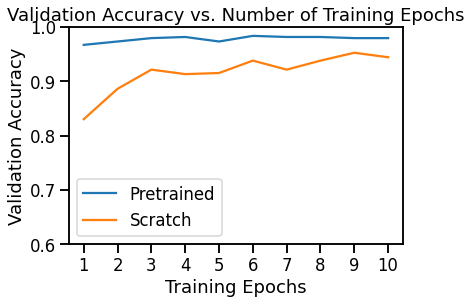

In [35]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0.6,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

##### save models

In [36]:
time_stamp = time.strftime('%Y-%m-%d_%H:%M:%S_%z')
torch.save(scratch_model.state_dict(), 'models/Scratch_CP_epoch_{}_{}_seed_{}.pth'.format(num_epochs, time_stamp, seed))
torch.save(model_ft.state_dict(), 'models/Pretrained_CP_epoch_{}_{}_seed_{}.pth'.format(num_epochs, time_stamp, seed))

-------

# Evaluation

# test set 
### created in the train/val/test split which inlcudes data from two matches

In [37]:
# step 1: load the models

In [40]:
pretrained, _ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
pretrained = load_trained_model(pretrained, model_path = 'models/Pretrained_CP_epoch_{}_{}_seed_{}.pth'.format(num_epochs, time_stamp, seed), device=device)

loading inception
[*] Loaded weights from models/Pretrained_CP_epoch_10_2020-09-18_22:29:47_+0000_seed_42.pth


In [41]:
scratch, _ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch = load_trained_model(scratch, model_path = 'models/Scratch_CP_epoch_{}_{}_seed_{}.pth'.format(num_epochs, time_stamp, seed), device=device)

loading inception
[*] Loaded weights from models/Scratch_CP_epoch_10_2020-09-18_22:29:47_+0000_seed_42.pth


In [42]:
# load test data

test = pd.read_csv('data/test.csv', index_col=[0])
test_data = FootballFrameDataset(test, transforms=None, normalize=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True, num_workers=0)

100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


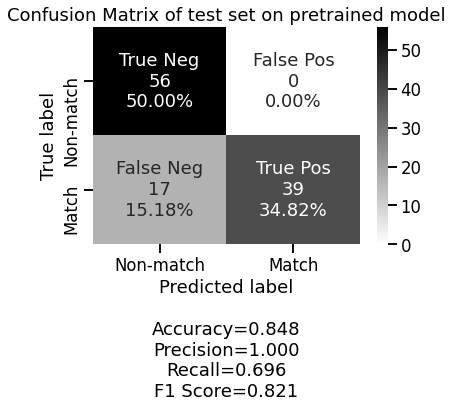

In [43]:
pretrained_stats = Evaluater(net = pretrained,
                             data_loader = test_loader,
                             categories = ['Non-match' ,'Match'], 
                             model_name = 'pretrained',
                             device=device)
pretrained_stats.eval_trained_model()
pretrained_stats.confustion_matrix()

100%|██████████| 12/12 [00:19<00:00,  1.61s/it]


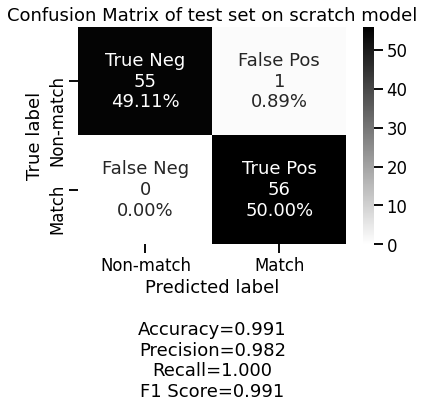

In [44]:
scratch_stats = Evaluater(net = scratch,
                             data_loader = test_loader,
                             categories = ['Non-match' ,'Match'], 
                             model_name = 'scratch',
                             device=device)
scratch_stats.eval_trained_model()
scratch_stats.confustion_matrix()

# evaluation on secret test set plus result saving

In [45]:
secret_path = "data/FrameFilter-test_set"
batch_size = 10

In [47]:
result_pretrained = eval_model_test_set(model = pretrained,
                                        test_path = secret_path,
                                        batch_size = batch_size,
                                        device=device)

600it [00:31, 19.17it/s]


In [48]:
result_scratch = eval_model_test_set(model = scratch,
                                     test_path = secret_path,
                                     batch_size = batch_size,
                                     device=device)

600it [00:32, 18.66it/s]


(array([139., 208., 120.,  55.,  38.,  17.,   9.,  10.,   2.,   2.]),
 array([0.04212783, 0.09640324, 0.15067866, 0.20495408, 0.2592295 ,
        0.31350492, 0.36778034, 0.42205576, 0.47633118, 0.5306066 ,
        0.58488202]),
 <a list of 10 Patch objects>)

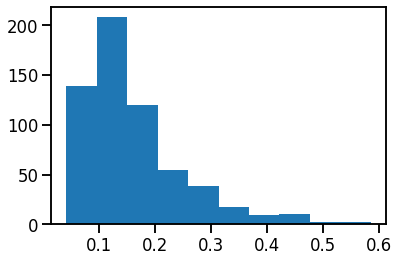

In [51]:
plt.hist(result_pretrained.probability)

(array([243., 127., 101.,  51.,  29.,  14.,  12.,  11.,   9.,   3.]),
 array([0.00141587, 0.10083962, 0.20026337, 0.29968712, 0.39911088,
        0.49853463, 0.59795838, 0.69738213, 0.79680589, 0.89622964,
        0.99565339]),
 <a list of 10 Patch objects>)

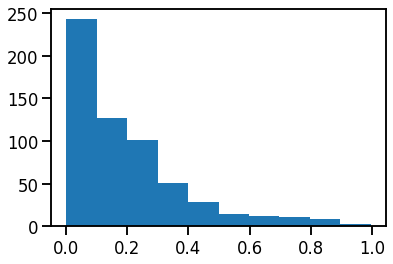

In [52]:
plt.hist(result_scratch.probability)

In [53]:
result_pretrained.to_csv("results/using_pretrained.csv")

In [54]:
result_scratch.to_csv("results/from_scratch.csv")